# Evaluate an Agent

In this tutorial, we are going to walk through 3 different evaluation strategies for LLM Systems. Basically, we'll evaluate three components of a system:

1. `Final Response`: Evaluate the agent's final response.
2. `Single step`: Evaluate any agent step in isolation (e.g., whether it selects the appropriate tool).
3. `Trajectory`: Evaluate whether the agent took the expected path (e.g., of tool calls) to arrive at the final answer.

Consider the following architecture for a SQL Agent:

<img src="../images/sql-agent.png" width="600">

This architecture suggests that we can evaluate the agent's final response, the agent's trajectory and the whether the expected tool call was invoked:

<img src="../images/sql-agent-eval.png" width="600">

So, based on that, let's build a SQL Agent and practice ways of evaluate that system.

In [1]:
# load environment variables
from dotenv import load_dotenv

load_dotenv()

True

## Configure the Database

The SQLite database we are going to use here is the [f1db](https://github.com/f1db/f1db/) database, which is the most comprehensive free open source database with all-time Formula 1 racing data and statistics.

In [1]:
import requests
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("./database/Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [2]:
from pprint import pprint
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///database/Chinook.db")

print(db.dialect)
pprint(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## SQL Agent

### LLM

In [3]:
from langchain_openai import ChatOpenAI

MODEL = "gpt-4o-mini"
TEMPERATURE = 0

llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)
experiment_prefix = "sql-agent-gpt4o"
metadata = "Chinook, gpt-4o-mini base-case-agent"

### Tools

We'll use SQL toolkit as well as some custom tools to check the query before executing it and check the query result from the database to confirm it is not empty or irrelevant to the question.

In [36]:
import json

from langchain_community.agent_toolkits import SQLDatabaseToolkit

from langgraph.graph import MessageGraph
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import tool


# SQL Toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Query checking
query_check_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""

query_check_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=query_check_prompt),
    HumanMessage(content="{query}")
])
query_check = query_check_prompt | llm

@tool
def check_query_tool(query: str) -> str:
    """
    Use this tool to double check if your query is correct before executing it.
    """
    return query_check.invoke({"query": query}).content


query_result_check_prompt = """
You are grading the result of a SQL query from a DB.
- Check that the result is not empty.
- If it is empty, instruct the system to re-try!
"""
query_result_check_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=query_result_check_prompt),
    HumanMessage(content="{query_result}")
])
query_result_check = query_result_check_prompt | llm


@tool
def check_result(query_result: str) -> str:
    """
    Use this tool to check the query result from the database to confirm it is not empty and is relevant
    """
    return query_result_check.invoke({"query_result": query_result}).content


tools.extend([check_query_tool, check_result])
tools

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x106a00690>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x106a00690>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x106a00690>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

### State

In [37]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Assistant

In [38]:
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable
        
    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # append to state
            state = {**state}
            
            # invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            
            # if it is a tool call -> response valid
            # if it has meaningful text -> response valid
            # otherwise, we re-prompt it b/c response is not meaningful
            no_tool_calls = not result.tool_calls
            no_content = not result.content
            content_is_list = isinstance(result.content, list)
            no_text_in_first_element = content_is_list and not result.content[0].get("text")

            # Combine the conditions in a more explicit way
            if no_tool_calls and (no_content or no_text_in_first_element):
                messages = state["messages"] + [HumanMessage(content="Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        
        return {"messages": result}

In [39]:
from langchain_core.prompts.chat import MessagesPlaceholder

query_gen_prompt = """
ROLE:
You are an agent designed to interact with a SQL database. You have access to tools for interacting with the database.
GOAL:
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
INSTRUCTIONS:
- Only use the below tools for the following operations.
- Only use the information returned by the below tools to construct your final answer.
- To start you should ALWAYS look at the tables in the database to see what you can query. Do NOT skip this step.
- Then you should query the schema of the most relevant tables.
- Write your query based upon the schema of the tables. You MUST double check your query before executing it.
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If the query returns a result, use check_result tool to check the query result.
- If the query result result is empty, think about the table schema, rewrite the query, and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
"""

query_gen_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=query_gen_prompt),
    MessagesPlaceholder(variable_name="messages")
])
assistant_runnable = query_gen_prompt | llm.bind_tools(tools)

### Graph

#### Utilities

In [40]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt.tool_node import ToolNode

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }
    

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

#### Build Graph

In [41]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

# nodes
builder.add_node("assistant", Assistant(runnable=assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    {
        "tools": "tools",
        END: END
    }
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

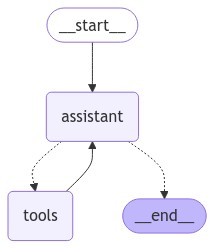

In [42]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

#### Run Example

In [43]:
questions = ["Which country's customers spent the most? And how much did they spend?",
             "How many albums does the artist Led Zeppelin have?",
             "What was the most purchased track of 2017?",
             "Which sales agent made the most in sales in 2009?"]

In [44]:
# invoke
import uuid

_printed = set()
thread_id = str(uuid.uuid4())
print(f"thread_id: {thread_id}")

config = {"configurable": {"thread_id": thread_id}}

msg = {"messages": HumanMessage(content=questions[0])}
for event in graph.stream(msg, config, stream_mode="values"):
    _print_event(event, _printed)

thread_id: 1e9129c7-3a3d-4a72-9d55-7266c327ad19
================================ Human Message =================================

Which country's customers spent the most? And how much did they spend?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_jl3pn8EUm3lPuZVdJcV4sJDf)
 Call ID: call_jl3pn8EUm3lPuZVdJcV4sJDf
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_hgGG5LOvwsTw4QV7jYJhqnXC)
 Call ID: call_hgGG5LOvwsTw4QV7jYJhqnXC
  Args:
    table_names: Customer
  sql_db_schema (call_VUn1qRzAulCekfskIRQHBYGh)
 Call ID: call_VUn1qRzAulCekfskIRQHBYGh
  Args:
    table_names: Invoice
  sql_db_schema (call_rsTL6AzxQSndx6oij9PXycsB)
 Call ID

## Evaluation

### Response Evaluation

First, we are going to evaluate how the agent system performs overall. Basically, we will treat the whole system as a black box and only care about the user input and final output.

For that we need to create a dataset that evaluates end-to-end performance of the agent.

In [14]:
import os 
os.environ["LANGCHAIN_PROJECT"] = "agent-evaluation"

In [46]:
# Create dataset
from langsmith import Client

client = Client()

examples = [
    ("Which country's customers spent the most? And how much did they spend?", 
     "The country whose customers spent the most is the USA, with a total expenditure of $523.06"),
    ("What was the most purchased track of 2013?", 
     "The most purchased track of 2013 was Hot Girl."),
    ("How many albums does the artist Led Zeppelin have?", 
     "Led Zeppelin has 14 albums"),
    ("What is the total price for the album “Big Ones”?", 
     "The total price for the album 'Big Ones' is 14.85"),
    ("Which sales agent made the most in sales in 2009?", 
     "Steve Johnson made the most sales in 2009"),
]

dataset_name = "SQL Agent Response"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[
            ({"input": text}, {"output": label}) for text, label in examples
        ]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

In [47]:
# run the chain
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": HumanMessage(content=example["input"])}
    # note that we are invoking graph
    messages = graph.invoke(msg, config)
    return {"response": messages["messages"][-1].content}

In [70]:
# evaluator
from langchain import hub
from langchain_openai import ChatOpenAI

# grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")
print(grade_prompt_answer_accuracy.messages[0].prompt.template)

print("="*50)
print("Input Variables: ", grade_prompt_answer_accuracy.input_variables)

You are a teacher grading a quiz. 

You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER. 

Here is the grade criteria to follow:
(1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer. 
(2) Ensure that the student answer does not contain any conflicting statements.
(3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.

Score:
A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 
A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset.
Input Variables:  ['correct_answer', 'question', 'student_answer']


In [71]:
def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """
    
    # get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]
    
    # LLM grader
    llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)
    
    # structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm
    
    # run evaluator
    score = answer_grader.invoke({
        "question": input_question,
        "correct_answer": reference,
        "student_answer": prediction
    })
    score = score["Score"]
    
    return {"key": "answer_v_reference_score", "score": score}

In [73]:
# create evaluation
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    predict_sql_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix=experiment_prefix + "-response-v-reference",
    num_repetitions=3,
    metadata={"version": metadata}
)

View the evaluation results for experiment: 'sql-agent-gpt4o-response-v-reference-2b1c58da' at:
https://smith.langchain.com/o/7733aa42-7fa1-584c-b6b6-3775fbe407d6/datasets/58a182eb-911e-4749-8801-4e135c82df2b/compare?selectedSessions=3dc6ad4d-2689-4af7-a253-0f6e1dcd6976




15it [00:14,  1.02it/s]


### Single Step Evaluation

Now, instead of evaluating the overall system output, we are going to evaluate a single step, which basically involves evaluating the tool calls in our case.

We can check a specific tool call using a [custom evaluator](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-custom-evaluators):

- Here, we just invoke the assistant, assistant_runnable, with a prompt and check if the resulting tool call is as expected.
- Here, we are using a specialized agent where the tools are hard-coded (rather than passed with the dataset input).
- We specify the reference tool call for the step that we are evaluating, expected_tool_call.

In [87]:
from langsmith.schemas import Example, Run

def predict_assistant(example: dict):
    """Invoke assistant for a single tool call evaluation"""
    msg = [HumanMessage(content=example["input"])]
    # note that we are invoking the assistant (prompt + llm)
    result = assistant_runnable.invoke({"messages": msg})
    return {"response": result}

def check_specific_tool_call(root_run: Run, example: Example) -> dict:
    """
    Check if the first tool call in the response matches the expected tool call.
    """
    # expected tool call
    expected_tool_call = "sql_db_list_tables"
    
    # run
    response = root_run.outputs["response"]
    
    # Get tool call
    try:
        tool_call = getattr(response, 'tool_calls', [])[0]['name']
    except (IndexError, KeyError):
        tool_call = None

    score = 1 if tool_call == expected_tool_call else 0
    return {"score": score, "key": "single_tool_call"}

experiment_results = evaluate(
    predict_assistant,
    data=dataset_name,
    evaluators=[check_specific_tool_call],
    experiment_prefix=experiment_prefix + "-single-tool",
    num_repetitions=3,
    metadata={"version": metadata}
)

View the evaluation results for experiment: 'sql-agent-gpt4o-single-tool-ad1a6cf3' at:
https://smith.langchain.com/o/7733aa42-7fa1-584c-b6b6-3775fbe407d6/datasets/58a182eb-911e-4749-8801-4e135c82df2b/compare?selectedSessions=3c8e6468-6130-4b84-8899-84a62055ac3d




15it [00:03,  4.97it/s]


### Trajectory Evaluation

We can check a trajectory of tool calls using custom evaluators:

- Here, we just invoke the agent, `graph.invoke`, with a prompt.
- Here, we are using a specialized agent where the tools are hard-coded (rather than passed with the dataset input).
- We extract the list of tools called, using `find_tool_calls`.
- Custom functions can process these tool calls in various user-defined ways.
- We can check if all expected tools are called in any order: `contains_all_tool_calls_any_order`
- We can check if all expected tools are called in order, allowing for insertion of tool calls: `contains_all_tool_calls_in_order`
- We can check if all expected tools are called in the exact order: `contains_all_tool_calls_in_order_exact_match`


In [99]:
def predict_sql_agent_messages(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": HumanMessage(content=example["input"])}
    # note that we invoke the graph
    messages = graph.invoke(msg, config)
    return {"response": messages}


def find_tool_calls(messages):
    """Find all tool calls in the messages returned"""
    tool_calls = [tc["name"] for m in messages["messages"] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls


def contains_all_tool_calls_any_order(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in any order.
    """
    expected = ['sql_db_query_checker', 'sql_db_query', 'sql_db_schema', 'sql_db_list_tables']
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    # Optionally, log the tool calls -
    # print("Here are my tool calls:")
    # print(tool_calls)
    if set(expected) == set(tool_calls):
        score = 1
    else:
        score = 0
    return {"score": int(score), "key": "multi_tool_call_any_order"}


def contains_all_tool_calls_in_order(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order.
    """
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    # Optionally, log the tool calls -
    # print("Here are my tool calls:")
    # print(tool_calls)
    expected = ['sql_db_query_checker', 'sql_db_query', 'sql_db_schema', 'sql_db_list_tables']
    for tool_call in tool_calls:
        if tool_call in expected:
            if len(expected) > 1:
                expected = expected[1:]
            else:
                expected = []
    
    if len(expected) == 0:
        score = 1
    else:
        score = 0
    return {"score": int(score), "key": "multi_tool_call_in_order"}


def contains_all_tool_calls_in_order_exact_match(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    expected = ['sql_db_list_tables',  'sql_db_schema', 'sql_db_query_checker', 'sql_db_query']
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    # Optionally, log the tool calls -
    # print("Here are my tool calls:")
    # print(tool_calls)
    tool_calls_order = []
    for tool_call in tool_calls:
        if tool_call not in tool_calls_order:
            tool_calls_order.append(tool_call)
            
    if tool_calls_order == expected:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "multi_tool_call_in_exact_order"}


experiment_results = evaluate(
    predict_sql_agent_messages,
    data=dataset_name,
    evaluators=[contains_all_tool_calls_any_order, contains_all_tool_calls_in_order, contains_all_tool_calls_in_order_exact_match],
    experiment_prefix=experiment_prefix + "-trajectory",
    num_repetitions=3,
    metadata={"version": metadata}
)

View the evaluation results for experiment: 'sql-agent-gpt4o-trajectory-3e5dd639' at:
https://smith.langchain.com/o/7733aa42-7fa1-584c-b6b6-3775fbe407d6/datasets/58a182eb-911e-4749-8801-4e135c82df2b/compare?selectedSessions=365bd7b3-e04b-495f-8738-1b1bf5cff027




15it [00:25,  1.72s/it]
